In [1]:
!pip install git+https://github.com/handley-lab/blackjax
!pip install anesthetic tqdm
# Advanced extensions (optional for Parts 4-6)
!pip install optax flax

# Note: Installation may take 2-3 minutes in Google Colab

  Cloning https://github.com/handley-lab/blackjax to /tmp/pip-req-build-nx0lozu4
  Running command git clone --filter=blob:none --quiet https://github.com/handley-lab/blackjax /tmp/pip-req-build-nx0lozu4


  Resolved https://github.com/handley-lab/blackjax to commit 41daed716462cc4b57af9da42aefb1eb27a532bb


  Installing build dependencies ... -

 \

 done


  Getting requirements to build wheel ... -

 done


  Preparing metadata (pyproject.toml) ... -

 done


# BlackJAX Nested Sampling Workshop

 This workshop demonstrates GPU-native nested sampling using BlackJAX. We'll progress through three examples: line fitting, 2D Gaussian inference, and performance comparisons with other samplers. The workshop showcases JAX's key strengths: automatic differentiation and JIT compilation for high-performance Bayesian inference.

## Installation for Google Colab
```bash
 pip install git+https://github.com/handley-lab/blackjax@nested_sampling
 pip install anesthetic tqdm
```

In [2]:
import jax

Configure JAX immediately after import

In [3]:
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import time
import blackjax
from anesthetic import NestedSamples

## Part 1: Line Fitting with Nested Sampling

 We start with the classic problem of fitting a linear model y = mx + c to noisy data.
 This introduces the basic nested sampling workflow in BlackJAX.

### 1.1 Nested Sampling Configuration
 
 Key parameters for workshop timing and educational value:
 - `num_live=100`: Fast convergence for workshop setting
 - `num_delete=50`: Parallelization parameter
 - `num_inner_steps`: Reliability parameter (rule of thumb: 5 * num_dims)

In [4]:
rng_key = jax.random.PRNGKey(42)
num_live = 100
num_delete = 50

### 1.2 Generate Synthetic Line Data

 True model: y = 2x + 1 + noise, with σ = 0.5

In [5]:
num_data = 15
x = jnp.linspace(-2.0, 2.0, num_data)
true = {'m': 2.0, 'c': 1.0, 'sigma': 0.5}

key, rng_key = jax.random.split(rng_key)
noise = true['sigma'] * jax.random.normal(key, (num_data,))
y = true['m'] * x + true['c'] + noise

Visualize the data

Text(0.5, 1.0, 'Linear Model: Bayesian Parameter Estimation')

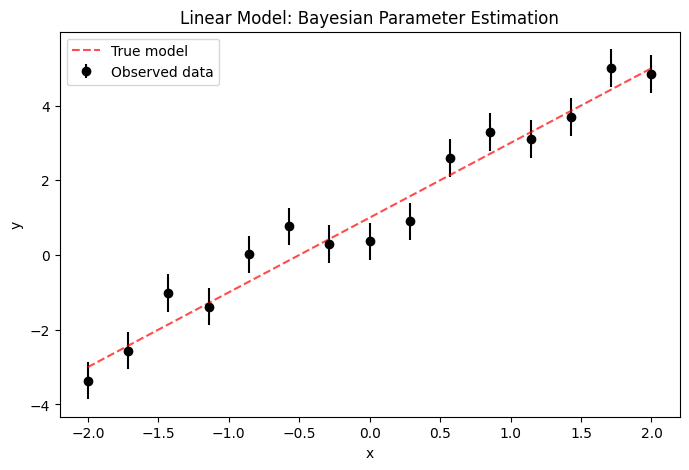

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, yerr=true['sigma'], fmt="o", label="Observed data", color='black')
ax.plot(x, true['m'] * x + true['c'], '--', label="True model", color='red', alpha=0.7)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.set_title("Linear Model: Bayesian Parameter Estimation")

### 1.3 Define Likelihood Function

 Gaussian likelihood with unknown slope, intercept, and noise level

In [7]:
def line_loglikelihood(params):
    """Log-likelihood for linear model with Gaussian noise."""
    m, c, sigma = params["m"], params["c"], params["sigma"]
    y_model = m * x + c
    # Vectorized normal log-likelihood
    return jax.scipy.stats.multivariate_normal.logpdf(y, y_model, sigma**2)

### 1.4 Define Prior Distributions

In [8]:
prior_bounds = {
    "m": (-5.0, 5.0),      # slope
    "c": (-5.0, 5.0),      # intercept  
    "sigma": (0.1, 2.0),   # noise level (positive)
}

num_dims = len(prior_bounds)
num_inner_steps = num_dims * 5

### 1.5 Initialize Nested Sampler

In [9]:
rng_key, prior_key = jax.random.split(rng_key)
particles, logprior_fn = blackjax.ns.utils.uniform_prior(prior_key, num_live, prior_bounds)

nested_sampler = blackjax.nss(
    logprior_fn=logprior_fn,
    loglikelihood_fn=line_loglikelihood,
    num_delete=num_delete,
    num_inner_steps=num_inner_steps,
)
print(f"Initialized nested sampler with {num_live} live points")

Initialized nested sampler with 100 live points


### 1.6 JIT Compile for Performance

In [10]:
init_fn = jax.jit(nested_sampler.init)
step_fn = jax.jit(nested_sampler.step)
print("Functions compiled - ready to run!")

Functions compiled - ready to run!


### 1.7 Run the Nested Sampling

In [11]:
print("Running nested sampling for line fitting...")
ns_start = time.time()
live = init_fn(particles)
dead = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not live.logZ_live - live.logZ < -3:  # Convergence criterion
        rng_key, subkey = jax.random.split(rng_key, 2)
        live, dead_info = step_fn(subkey, live)
        dead.append(dead_info)
        pbar.update(num_delete)

dead = blackjax.ns.utils.finalise(live, dead)
ns_time = time.time() - ns_start

Running nested sampling for line fitting...


Dead points: 0 dead points [00:00, ? dead points/s]

Dead points: 50 dead points [00:02, 20.08 dead points/s]

Dead points: 900 dead points [00:02, 356.14 dead points/s]

### 1.8 Process Results with Anesthetic

In [12]:
columns = ["m", "c", "sigma"]
labels = [r"$m$", r"$c$", r"$\sigma$"]
data = jnp.vstack([dead.particles[key] for key in columns]).T

line_samples = NestedSamples(
    data,
    logL=dead.loglikelihood,
    logL_birth=dead.loglikelihood_birth,
    columns=columns,
    labels=labels,
    logzero=jnp.nan,
)

### 1.9 Results Analysis and Visualization

Nested sampling runtime: 2.99 seconds
Log Evidence: -20.05 ± 0.34
True parameters: m=2.0, c=1.0, σ=0.5
Posterior means: m=1.97, c=1.11, σ=0.60


Text(0.5, 0.98, 'Line Fitting: Posterior Distributions')

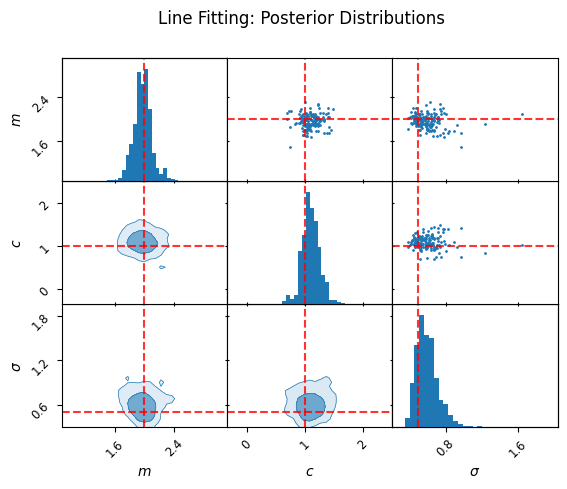

In [13]:
print(f"Nested sampling runtime: {ns_time:.2f} seconds")
print(f"Log Evidence: {line_samples.logZ():.2f} ± {line_samples.logZ(100).std():.2f}")
print(f"True parameters: m={true['m']}, c={true['c']}, σ={true['sigma']}")
print(f"Posterior means: m={line_samples.m.mean():.2f}, c={line_samples.c.mean():.2f}, σ={line_samples.sigma.mean():.2f}")

# Create posterior corner plot with true values marked
kinds = {'lower': 'kde_2d', 'diagonal': 'hist_1d', 'upper': 'scatter_2d'}
axes = line_samples.plot_2d(columns, kinds=kinds, label='Posterior')
axes.axlines(true, color='red', linestyle='--', alpha=0.8)
plt.suptitle("Line Fitting: Posterior Distributions")

## Part 2: 2D Gaussian Parameter Inference

 Now we tackle a more complex problem: inferring the parameters of a 2D Gaussian distribution
 including the correlation coefficient. This demonstrates parameter transforms and constrained sampling.

### 2.1 Define 2D Gaussian Parameters

In [14]:
true.update({
    'mu1': 1.0, 'mu2': -0.5,
    'sigma1': 1.2, 'sigma2': 0.8, 
    'rho': 0.6
})
print("True parameters:", {k: v for k, v in true.items() if k in ['mu1', 'mu2', 'sigma1', 'sigma2', 'rho']})

True parameters: {'mu1': 1.0, 'mu2': -0.5, 'sigma1': 1.2, 'sigma2': 0.8, 'rho': 0.6}


### 2.2 Generate Correlated 2D Data

In [15]:
true_mu = jnp.array([true['mu1'], true['mu2']])
true_cov = jnp.array([
    [true['sigma1']**2, true['rho'] * true['sigma1'] * true['sigma2']],
    [true['rho'] * true['sigma1'] * true['sigma2'], true['sigma2']**2]
])

num_samples = 200
key, rng_key = jax.random.split(rng_key)
gaussian_data = jax.random.multivariate_normal(key, true_mu, true_cov, (num_samples,))

print(f"Generated {num_samples} correlated 2D samples")
print(f"Sample mean: [{gaussian_data.mean(0)[0]:.2f}, {gaussian_data.mean(0)[1]:.2f}]")

Generated 200 correlated 2D samples
Sample mean: [1.06, -0.39]


### 2.3 Visualize the 2D Data

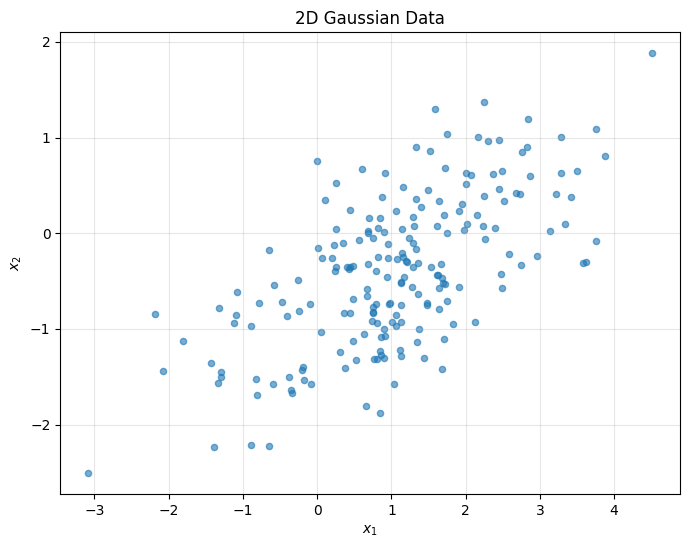

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(gaussian_data[:, 0], gaussian_data[:, 1], alpha=0.6, s=20)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title("2D Gaussian Data")
ax.grid(True, alpha=0.3)

### 2.4 Define Likelihood with Parameter Transforms

 We use arctanh/tanh transform for the correlation coefficient to enforce |ρ| < 1

In [17]:
def gaussian_2d_loglikelihood(params):
    """Log-likelihood for 2D Gaussian with correlation."""
    mu1, mu2 = params["mu1"], params["mu2"]
    sigma1, sigma2 = params["sigma1"], params["sigma2"]
    rho_transformed = params["rho_t"]
    
    # Transform correlation coefficient: rho = tanh(rho_t)
    rho = jnp.tanh(rho_transformed)
    
    # Construct covariance matrix
    cov = jnp.array([
        [sigma1**2, rho * sigma1 * sigma2],
        [rho * sigma1 * sigma2, sigma2**2]
    ])
    
    # Check positive definiteness
    det = jnp.linalg.det(cov)
    
    # Return -inf for invalid covariance matrices
    def valid_loglik():
        mu = jnp.array([mu1, mu2])
        return jnp.sum(jax.scipy.stats.multivariate_normal.logpdf(gaussian_data, mu, cov))
    
    def invalid_loglik():
        return -jnp.inf
    
    return jax.lax.cond(det > 1e-8, valid_loglik, invalid_loglik)

### 2.5 Set Up Priors for 2D Gaussian

In [18]:
gaussian_prior_bounds = {
    "mu1": (-3.0, 5.0),
    "mu2": (-3.0, 3.0), 
    "sigma1": (0.1, 3.0),
    "sigma2": (0.1, 3.0),
    "rho_t": (-2.0, 2.0),  # transformed correlation: rho = tanh(rho_t)
}

num_dims_2d = len(gaussian_prior_bounds)
num_inner_steps_2d = num_dims_2d * 5

### 2.6 Initialize and Run Nested Sampling

In [19]:
rng_key, prior_key = jax.random.split(rng_key)
particles_2d, logprior_fn_2d = blackjax.ns.utils.uniform_prior(prior_key, num_live, gaussian_prior_bounds)

nested_sampler_2d = blackjax.nss(
    logprior_fn=logprior_fn_2d,
    loglikelihood_fn=gaussian_2d_loglikelihood,
    num_delete=num_delete,
    num_inner_steps=num_inner_steps_2d,
)

init_fn_2d = jax.jit(nested_sampler_2d.init)
step_fn_2d = jax.jit(nested_sampler_2d.step)

print("Running nested sampling for 2D Gaussian...")
live_2d = init_fn_2d(particles_2d)
dead_2d = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not live_2d.logZ_live - live_2d.logZ < -3:
        rng_key, subkey = jax.random.split(rng_key, 2)
        live_2d, dead_info_2d = step_fn_2d(subkey, live_2d)
        dead_2d.append(dead_info_2d)
        pbar.update(num_delete)

dead_2d = blackjax.ns.utils.finalise(live_2d, dead_2d)

Running nested sampling for 2D Gaussian...


Dead points: 0 dead points [00:00, ? dead points/s]

Dead points: 50 dead points [00:03, 15.02 dead points/s]

Dead points: 250 dead points [00:03, 95.73 dead points/s]

Dead points: 450 dead points [00:03, 198.72 dead points/s]

Dead points: 650 dead points [00:03, 325.80 dead points/s]

Dead points: 850 dead points [00:03, 476.32 dead points/s]

Dead points: 1050 dead points [00:03, 645.72 dead points/s]

Dead points: 1250 dead points [00:04, 824.48 dead points/s]

Dead points: 1400 dead points [00:04, 339.60 dead points/s]

### 2.7 Transform Back and Analyze Results

In [20]:
columns_2d = ["mu1", "mu2", "sigma1", "sigma2", "rho_t"]
labels_2d = [r"$\mu_1$", r"$\mu_2$", r"$\sigma_1$", r"$\sigma_2$", r"$\rho_t$"]
data_2d = jnp.vstack([dead_2d.particles[key] for key in columns_2d]).T

gaussian_samples = NestedSamples(
    data_2d,
    logL=dead_2d.loglikelihood,
    logL_birth=dead_2d.loglikelihood_birth,
    columns=columns_2d,
    labels=labels_2d,
    logzero=jnp.nan,
)

Add transformed correlation coefficient

In [21]:
gaussian_samples["rho"] = jnp.tanh(gaussian_samples["rho_t"].values)

print(f"Log Evidence: {gaussian_samples.logZ():.2f} ± {gaussian_samples.logZ(100).std():.2f}")
print(f"True parameters: μ₁={true['mu1']:.2f}, μ₂={true['mu2']:.2f}, σ₁={true['sigma1']:.2f}, σ₂={true['sigma2']:.2f}, ρ={true['rho']:.2f}")
print(f"Posterior means: μ₁={gaussian_samples.mu1.mean():.2f}, μ₂={gaussian_samples.mu2.mean():.2f}, σ₁={gaussian_samples.sigma1.mean():.2f}, σ₂={gaussian_samples.sigma2.mean():.2f}, ρ={gaussian_samples.rho.mean():.2f}")

Log Evidence: -528.61 ± 0.44
True parameters: μ₁=1.00, μ₂=-0.50, σ₁=1.20, σ₂=0.80, ρ=0.60
Posterior means: μ₁=1.06, μ₂=-0.38, σ₁=1.27, σ₂=0.80, ρ=0.64


Plot posterior for key parameters with true values

Text(0.5, 0.98, '2D Gaussian: Posterior Parameter Estimates')

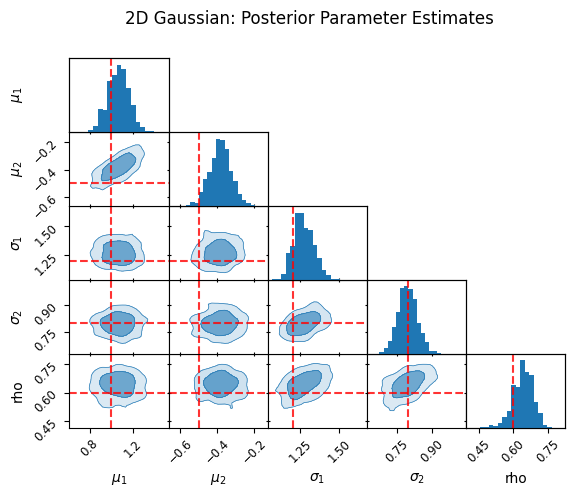

In [22]:
key_params = ["mu1", "mu2", "sigma1", "sigma2", "rho"]
axes = gaussian_samples[key_params].plot_2d(key_params, kinds={'diagonal': 'hist_1d', 'lower': 'kde_2d'})

# Mark true values using anesthetic's axlines method
true_2d = {k: true[k] for k in key_params}
axes.axlines(true_2d, color='red', linestyle='--', alpha=0.8)
plt.suptitle("2D Gaussian: Posterior Parameter Estimates")

## Part 3: Performance Comparison

 Compare BlackJAX nested sampling with NUTS (No-U-Turn Sampler) and 
 Affine Invariant Ensemble Sampler on the line fitting problem

In [23]:
import time

### 3.1 Define NUTS Log-Probability Function

In [24]:
def nuts_logprob(params_array):
    """Combined log probability for NUTS (assumes flat priors within bounds)."""
    m, c, log_sigma = params_array
    sigma = jnp.exp(log_sigma)  # positive constraint via log transform
    
    # Check bounds (flat prior)
    m_valid = (m >= -5.0) & (m <= 5.0)
    c_valid = (c >= -5.0) & (c <= 5.0)
    sigma_valid = (sigma >= 0.1) & (sigma <= 2.0)
    
    def valid_logprob():
        y_model = m * x + c
        loglik = jax.scipy.stats.multivariate_normal.logpdf(y, y_model, sigma**2)
        return loglik + log_sigma  # Add Jacobian for log transform
    
    def invalid_logprob():
        return -jnp.inf
    
    return jax.lax.cond(m_valid & c_valid & sigma_valid, valid_logprob, invalid_logprob)

### 3.2 Initialize and Run NUTS Sampler

In [25]:
initial_position = jnp.array([1.0, 0.0, jnp.log(1.0)])  # [m, c, log_sigma]
nuts = blackjax.nuts(nuts_logprob, step_size=0.1, inverse_mass_matrix=jnp.eye(3))

rng_key, nuts_key = jax.random.split(rng_key)
nuts_state = nuts.init(initial_position)
nuts_step = jax.jit(nuts.step)

print("Running NUTS sampler...")

num_nuts_samples = 2000
nuts_start = time.time()
nuts_samples = []
nuts_states = nuts_state

for i in tqdm.tqdm(range(num_nuts_samples), desc="NUTS"):
    nuts_key, step_key = jax.random.split(nuts_key)
    nuts_states, nuts_info = nuts_step(step_key, nuts_states)
    nuts_samples.append(nuts_states.position)

nuts_time = time.time() - nuts_start
nuts_samples = jnp.stack(nuts_samples)

Running NUTS sampler...


NUTS:   0%|          | 0/2000 [00:00<?, ?it/s]

NUTS:   0%|          | 1/2000 [00:01<38:02,  1.14s/it]

NUTS:  19%|█▉        | 381/2000 [00:01<00:03, 423.28it/s]

NUTS:  38%|███▊      | 760/2000 [00:01<00:01, 884.57it/s]

NUTS:  58%|█████▊    | 1156/2000 [00:01<00:00, 1387.99it/s]

NUTS:  77%|███████▋  | 1546/2000 [00:01<00:00, 1863.85it/s]

NUTS:  97%|█████████▋| 1937/2000 [00:01<00:00, 2299.68it/s]

NUTS: 100%|██████████| 2000/2000 [00:01<00:00, 1200.07it/s]

### 3.3 Process NUTS Results

In [26]:
nuts_m = nuts_samples[:, 0]
nuts_c = nuts_samples[:, 1] 
nuts_sigma = jnp.exp(nuts_samples[:, 2])

print(f"NUTS runtime: {nuts_time:.2f} seconds")
print(f"NUTS means: m={nuts_m[500:].mean():.2f}, c={nuts_c[500:].mean():.2f}, σ={nuts_sigma[500:].mean():.2f}")

NUTS runtime: 1.67 seconds
NUTS means: m=1.98, c=1.11, σ=0.60


### 3.4 Performance Summary and Visualization

In [27]:
methods = ["Nested Sampling", "NUTS"]
times = [f"{ns_time:.1f} sec", f"{nuts_time:.1f} sec"]
evidence = ["✓ (Log Z available)", "✗ (Not computed)"]
parallelization = ["✓ (GPU native)", "Limited"]

print(f"{'Method':<20} {'Time':<15} {'Evidence':<15} {'GPU Parallel'}")
print("-" * 65)
for i in range(len(methods)):
    print(f"{methods[i]:<20} {times[i]:<15} {evidence[i]:<15} {parallelization[i]}")

Method               Time            Evidence        GPU Parallel
-----------------------------------------------------------------
Nested Sampling      3.0 sec         ✓ (Log Z available) ✓ (GPU native)
NUTS                 1.7 sec         ✗ (Not computed) Limited


### 3.5 Posterior Comparison Plot

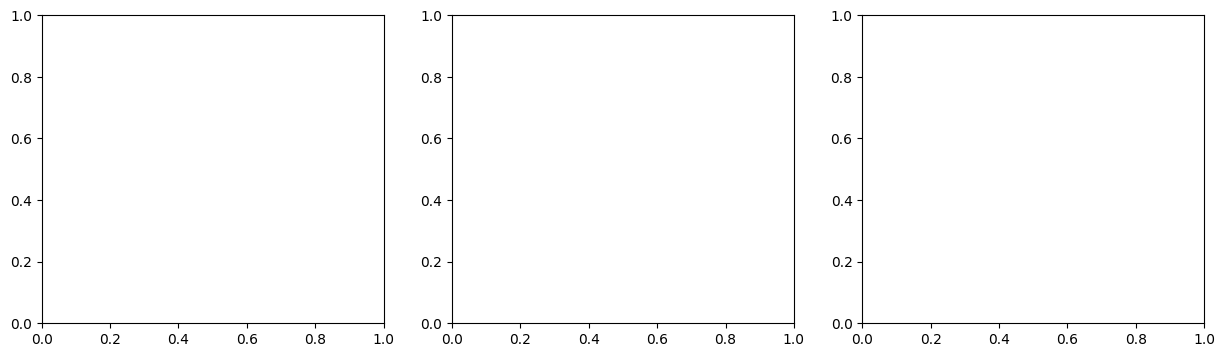

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

Generate proper posterior samples from NestedSamples (not raw dead points)
 Use the number of available samples or 1000, whichever is smaller

In [29]:
n_posterior_samples = min(1000, len(line_samples))
ns_posterior_samples = line_samples.sample(n_posterior_samples, replace=True)  # Sample from posterior with replacement
nuts_burnin = 500  # Remove burn-in

Compare marginal posteriors

In [30]:
axes[0].hist(ns_posterior_samples.m.values, bins=30, alpha=0.7, density=True, label='Nested Sampling')
axes[0].hist(nuts_m[nuts_burnin:], bins=30, alpha=0.7, density=True, label='NUTS')
axes[0].axvline(true['m'], color='red', linestyle='--', label='True value')
axes[0].set_xlabel('Slope (m)')
axes[0].set_ylabel('Density')
axes[0].legend()

axes[1].hist(ns_posterior_samples.c.values, bins=30, alpha=0.7, density=True, label='Nested Sampling')
axes[1].hist(nuts_c[nuts_burnin:], bins=30, alpha=0.7, density=True, label='NUTS')
axes[1].axvline(true['c'], color='red', linestyle='--', label='True value')
axes[1].set_xlabel('Intercept (c)')
axes[1].set_ylabel('Density')
axes[1].legend()

axes[2].hist(ns_posterior_samples.sigma.values, bins=30, alpha=0.7, density=True, label='Nested Sampling')
axes[2].hist(nuts_sigma[nuts_burnin:], bins=30, alpha=0.7, density=True, label='NUTS')
axes[2].axvline(true['sigma'], color='red', linestyle='--', label='True value')
axes[2].set_xlabel('Noise (σ)')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout()
plt.suptitle("Posterior Comparison: Nested Sampling vs NUTS", y=1.02)

Text(0.5, 1.02, 'Posterior Comparison: Nested Sampling vs NUTS')

<Figure size 640x480 with 0 Axes>